#  Cianjur 2022 Earthquake Interferogram Creation from Sentinel-1 Data 

![interferogram](resource/interferogram.JPG)

On 21 November 2022, a magnitude 5.6 SR earthquake struck the city of Cianjur, West Java, Indonesia and the nearby areas.

The goal of this work is to provide interferogram created from a pair of Sentinel-1A satellite. Sentinel-1 has temporal resolution of 6 days, with 12 days repeat cycle at equator with one satellite. The first image was obtained 2 days after the earthquake (23 November 2022), and the second one was taken on 11 November 2022, about 12 days prior the first image.

In this exact case, python module from ESA SNAP called snappy is utilized to pre-process the data. ESA SNAP is a toolbox for processing and analysis of Earth Observation data. The snappy module is "python add-on" for SNAP and makes it possible to create automation for certain processes.


In [1]:
import matplotlib.colors as colors 
import matplotlib.image as mpimg   
import matplotlib.pyplot as plt    
from termcolor import colored      #print colored text
from zipfile import ZipFile        #zip file manipulation
from os.path import join           #data access in file manager
from glob import iglob             #data access in file manager
import pandas as pd                
import numpy as np                 
import subprocess                  #external calls to system
import snappy                      #SNAP python interface
import jpy                         #python-java bridge
from PIL import Image

#change module settings
pd.options.display.max_colwidth = 90 #longer text in pandas dataframe

In the case of needing to know what operators available, it is possible to list them in snappy by calling gpt -h, while gpt -h *operator* will list the documentation of specific operator

In [1]:
#print(subprocess.Popen(['gpt','-h'], stdout=subprocess.PIPE, universal_newlines=True).communicate()[0]) #use this for full list 
#print(subprocess.Popen(['gpt','-h','TOPSAR-Split'], stdout=subprocess.PIPE, universal_newlines=True).communicate()[0]) #use this for specific operator

# Workflow

![alt text](workflow.jpg "Workflow")

Sentinel-1 has several products, Level 0 raw, Level 1 SLC (Single Look Complex), Level 1 GRD (Ground Range Detected), and Level 2 OCN ocean product.

For the purpose of producing interferogram that is useful for analysis in earthquake, Level 1 SLC is the one to be used.  

It has default acquisition mode over land called IW (Interferometric Wide Swath Mode) with TOPSAR (Terrain Observation with Progressive Scans SAR) technique and dual polarization (VV+VH). 

The TOPSAR technique images 3 sub swaths IW1, IW2, IW3 with total of 10 bursts for each sub. 

In general, the workflow goes as:

1. Read 1 and 2: each imagery needs to be read and be selected 
2. Split 1 and 2: then split by selecting the desired swath and bursts only
3. Apply Orbit 1 and 2 : will refine the orbit data for each imagery

4. Back Geocoding : coregistration based on the orbit information and additional information from a DEM (Digital Elevation Model)
5. Enhanced Spectral Diversity : calculate average constant range and azimuth offset estimation for the imagery, through estimation of each burst
6. Interferogram Creation : interferogram from two image-stacked product supplied from Back Geocoding and ESD
7. Deburst : deburst will remove the seamlines between single bursts
8. Topographic Phase Removal : removal of the topograhic phase by estimation and subtraction from the debursted interferogram
9. Multilook : reduce the speckle (salt and grain effect) noise that originally appears to SAR images and acquisition of square pixels 
10. Goldstein Phase Filtering : a phase filter by goldstein to further reduce the noise
11. Write : If desired, exporting to other format is also possible, for example as geotiff

,Name,Sensing Mode,Product Type,Polarization,Height,Width,Band Names
0,S1A_IW_SLC__1SDV_20221111T111506_20221111T111536_045845_057C1D_22C2,IW,SLC,1SDV,15030,70307,"[i_IW1_VH, q_IW1_VH, Intensity_IW1_VH, i_IW1_VV, q_IW1_VV, Intensity_IW1_VV,..."
1,S1A_IW_SLC__1SDV_20221123T111506_20221123T111536_046020_058209_DD11,IW,SLC,1SDV,15030,70307,"[i_IW1_VH, q_IW1_VH, Intensity_IW1_VH, i_IW1_VV, q_IW1_VV, Intensity_IW1_VV,..."


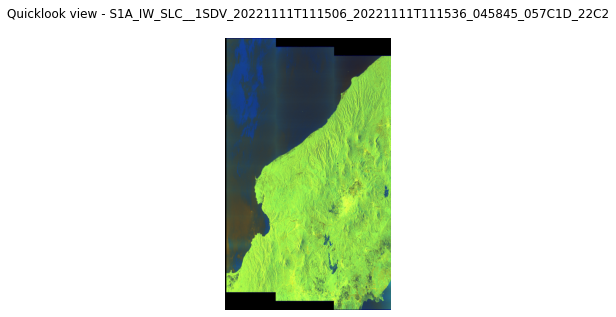

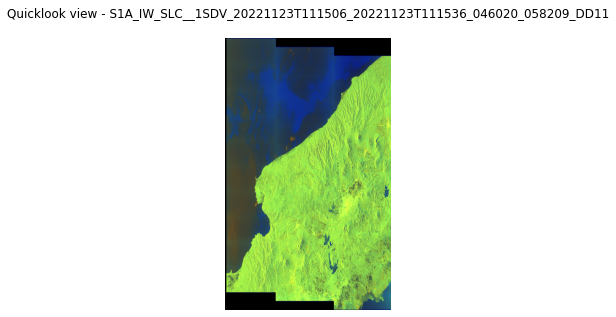

In [3]:
product_path = r"D:\Work\Deep Learning and Satellites\Cianjur_2022"
#input_files = sorted(list(iglob(os.path.join(product_path, "*.zip"), recursive=True))) #input all zip files without the ones inside the sub folder
input_files = sorted(list(iglob(join(product_path,"**", "*S1*.zip"), recursive=True))) #input all zip files including all inside the sub folder
    
name, sensing_mode, product_type, polarization, height, width, band_names = ([] for i in range(7))

for i in input_files:
    sensing_mode.append(i.split("_")[2])
    product_type.append(i.split("_")[3])
    polarization.append(i.split("_")[-6])
    #read using snappy
    data_read = snappy.ProductIO.readProduct(i)
    name.append(data_read.getName())
    height.append(data_read.getSceneRasterHeight())
    width.append(data_read.getSceneRasterWidth())
    band_names.append(data_read.getBandNames())
    
df_read = pd.DataFrame({'Name':name, 'Sensing Mode': sensing_mode, 'Product Type': product_type, 'Polarization': polarization, 'Height': height, 'Width': width, 'Band Names': band_names})
display(df_read)

# display quicklook.png that is the preview of the imageries located inside the zip files
# there are a pair, therefore two previews are displayed here
for i in range(len(input_files)):
    with ZipFile(input_files[i], 'r') as qlook:
        qlook = qlook.open(name[i] + '.SAFE/preview/quick-look.png')
        img = Image.open(qlook) #use PIL's Image
        
        plt.figure(figsize = (5,5))
        plt.title('Quicklook view - '+ name[i] + '\n')
        plt.axis('off')
        plt.imshow(img)

### TOPSAR-SPLIT

TOPSAR-SPLIT operator is useful to select specific bursts that is included for the analysis, this will affect for the reduction of processing time (instead of using full imagery which will be longer in overall processing time)

Sentinel-1 IW has 1-10 bursts. For this Cianjur interferogram creation case, only burst 7-8 selected to save processing time and basically chose the region of interest

In [5]:
def topsar_split(raster):

    parameters = snappy.HashMap()
    parameters.put('firstBurstIndex',7)
    parameters.put('lastBurstIndex',8)
    parameters.put('subswath', 'IW2')
    parameters.put('selectedPolarisations', 'VV')
    top_split = snappy.GPF.createProduct('TOPSAR-Split', parameters, raster)

    print("Split done")
    return top_split

#image1 = snappy.ProductIO.readProduct(S1B_IW_SLC__1SDV_20210209T072955_20210209T073025_025526_030AA1_1D17.zip)
#topsar_1 = topsar_split(input_files[0])
img_tmp1 = input_files[0].split("\\")[-1]
img1 = snappy.ProductIO.readProduct(img_tmp1)

topsar_1 = topsar_split(img1)

img_tmp2 = input_files[1].split("\\")[-1]
img2 = snappy.ProductIO.readProduct(img_tmp2)

topsar_2 = topsar_split(img2)

Split done
Split done


### Apply Orbit File

An operator to refine orbit data in order to provide accurate satellite position and velocity information

In [6]:
def apply_orbit(raster):

    parameters = snappy.HashMap()
    parameters.put('Apply-Orbit-File', True)
    apply_orbit_file = snappy.GPF.createProduct('Apply-Orbit-File', parameters, raster)

    print("Apply Orbit File done")
    return apply_orbit_file


apply_orbit1 = apply_orbit(topsar_1)
apply_orbit2 = apply_orbit(topsar_2)

Apply Orbit File done
Apply Orbit File done


### Back Geocoding

Back geocoding will perform coregistration based on the orbit information and additional information from a DEM (Digital Elevation Model)

In [7]:
parameters = snappy.HashMap()
parameters.put('demName', "SRTM 1Sec HGT")
parameters.put('demResamplingMethod', 'BICUBIC_INTERPOLATION')
parameters.put('resamplingType', 'BISINC_5_POINT_INTERPOLATION')
parameters.put('maskOutAreaWithoutElevation', True)
parameters.put('outputDerampDemodPhase', True)

sett = []
sett.append(apply_orbit1)
sett.append(apply_orbit2)

back_geocoded = snappy.GPF.createProduct('Back-Geocoding', parameters, sett) 
print("back geocoding done")

back geocoding done


### Enhanced Spectral Diversity

ESD operator will calculate average constant range and azimuth offset estimation for the imagery, through estimation of each burst

In [8]:
parameters = snappy.HashMap()
parameters.put('Enhanced-Spectral-Diversity', True)
esd = snappy.GPF.createProduct('Enhanced-Spectral-Diversity', parameters, back_geocoded)
print("Enhanced Spectral Diversity done")

Enhanced Spectral Diversity done


### Interferogram Creation

This operation marks the creation of the interferogram from two image-stacked product supplied from Back Geocoding and ESD from the previous steps

In [9]:
parameters = snappy.HashMap()
parameters.put('cohWinRg', 20)
interferogram = snappy.GPF.createProduct('Interferogram', parameters, esd) 
print("Interferogram Creation done")

Interferogram Creation done


### Deburst

There are visible seamline between bursts from Sentinel-1 Interferometric Wide Swath product. Deburst will remove the seamlines between single bursts

In [10]:
parameters = snappy.HashMap()
parameters.put('selectedPolarisations', 'VV')
debursted = snappy.GPF.createProduct('TOPSAR-Deburst', parameters, interferogram) 
print("Deburst done")

#a way to get list of the bands is :
#bands = list(debursted.getBandNames())
#bands

#ifg_VV = debursted.getBand('Phase_ifg_IW2_VV_23Nov2022_11Nov2022')
#w = ifg_VV.getRasterWidth()
#h = ifg_VV.getRasterHeight()
#ifg_VV_data = np.zeros(w * h, np.float32)
#ifg_VV.readPixels(0, 0, w, h, ifg_VV_data)
#debursted.dispose()
#ifg_VV_data.shape = h, w
#plt.imshow(ifg_VV_data)

Deburst done


### Topographic Phase Removal

Removal of the topograhic phase by estimation and subtraction from the debursted interferogram

In [11]:
parameters = snappy.HashMap()
parameters.put('demName', "SRTM 1Sec HGT")
parameters.put('outputTopoPhaseBand', True)
topo_remove = snappy.GPF.createProduct('TopoPhaseRemoval', parameters, debursted) 
print("Topographic Phase Removal done")

Topographic Phase Removal done


### Multilook

Multilook will reduce the speckle (salt and grain effect) noise that originally appears to SAR images and acquisition of square pixels 

In [12]:
parameters = snappy.HashMap()
parameters.put('nRgLooks', 8)

multilook = snappy.GPF.createProduct('Multilook', parameters, topo_remove) 
print("Multilook done")

Multilook done


### Goldstein Phase Filtering

A phase filter by goldstein to further reduce the noise

In [13]:
parameters = snappy.HashMap()
parameters.put('GoldsteinPhaseFiltering', True)
filtered = snappy.GPF.createProduct('GoldsteinPhaseFiltering', parameters, multilook)
print("Goldstein Phase Filtering done")

Goldstein Phase Filtering done


### Geometric/Terrain Correction

Apply geometric or terrain correction to the filtered image, so that the it has correct coordinate system. Useful if the imagery is desired to be plotted on web app , this is possible with folium or leaflet for example

In [14]:
parameters = snappy.HashMap()
parameters.put('demName', "SRTM 1Sec HGT")
parameters.put('demResamplingMethod', 'BICUBIC_INTERPOLATION')
parameters.put('imgResamplingMethod', 'BICUBIC_INTERPOLATION')
parameters.put('sourceBands', 'Intensity_ifg_VV_23Nov2022_11Nov2022_db, Phase_ifg_VV_23Nov2022_11Nov2022, topo_phase_VV_23Nov2022_11Nov2022, coh_IW2_VV_23Nov2022_11Nov2022')
parameters.put('saveSelectedSourceBand', True)
TC = snappy.GPF.createProduct('Terrain-Correction', parameters, filtered) 
print("Terrain Correction done")

bandsTC = list(TC.getBandNames())
bandsTC

Terrain Correction done


['Intensity_ifg_VV_23Nov2022_11Nov2022_db',
 'Phase_ifg_VV_23Nov2022_11Nov2022',
 'topo_phase_VV_23Nov2022_11Nov2022',
 'coh_IW2_VV_23Nov2022_11Nov2022']

### Plot the Geometrically Corrected Interferogram

A simple plot to show the geometrically corrected and filtered interferogram

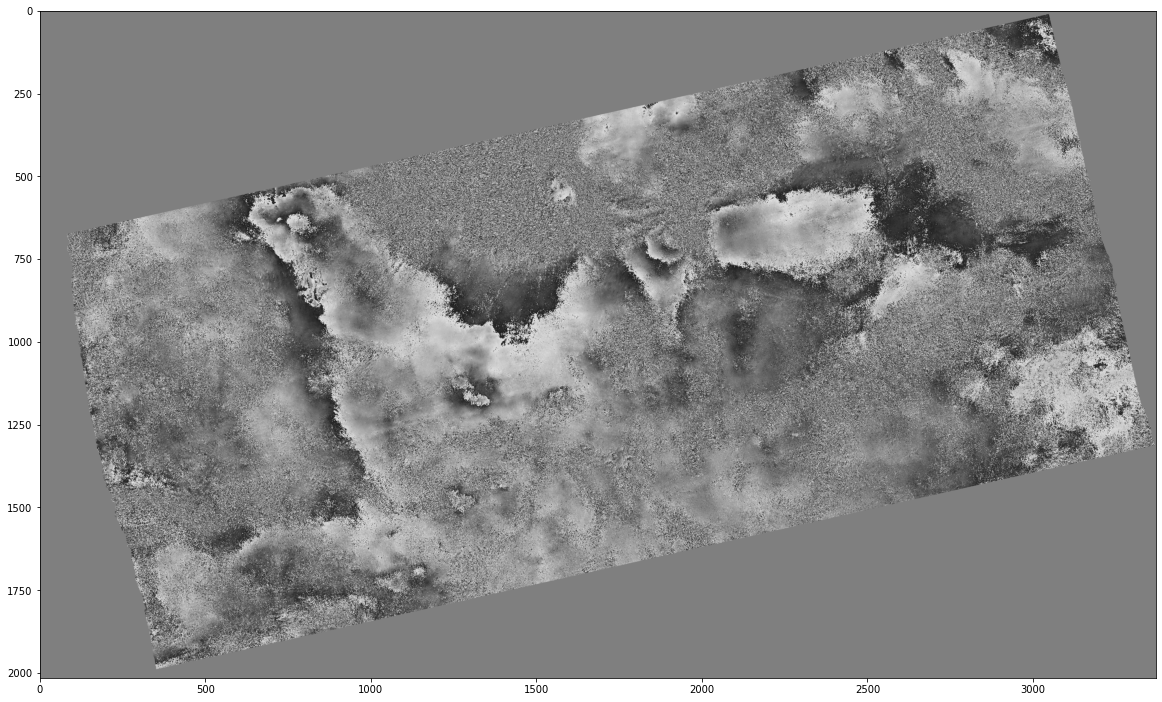

In [34]:
#after running this code, it will take a while before the image appears
ifg_VV = TC.getBand('Phase_ifg_VV_23Nov2022_11Nov2022')
w = ifg_VV.getRasterWidth()
h = ifg_VV.getRasterHeight()
ifg_VV_data = np.zeros(w * h, np.float32)
ifg_VV.readPixels(0, 0, w, h, ifg_VV_data)
#debursted.dispose()
ifg_VV_data.shape = h, w
plt.figure(figsize = (20,15))
plt.imshow(ifg_VV_data,cmap='gray',vmin=-3.964,vmax=3.997)


### Write/Export to Other formats

If desired, exporting to other format is also possible. The example below shows how to export the product in geotiff format: 

In [22]:
outname = r"D:\Work\Deep Learning and Satellites\Cianjur_2022\outname"
snappy.ProductIO.writeProduct(TC,outname,'geoTIFF')
print("successfully written !")

successfully written !
